In [1]:
import scanpy as sc
import scFates as scf
sc.set_figure_params(dpi_save=300)
scf.set_figure_pubready()

In [2]:
adata=sc.read("data/adata_tree.h5ad")

In [3]:
import pandas as pd
ms_data=pd.DataFrame(adata.obsm['X_msdiff'],index=adata.obs_names)

In [4]:
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


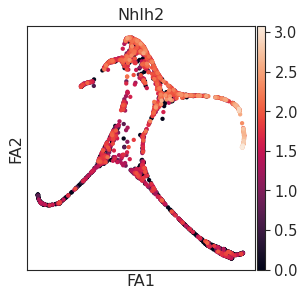

In [5]:
%matplotlib inline
sc.pl.draw_graph(adata,color="Nhlh2")

In [6]:
start_cell=adata.obs_names[adata[:,"Nhlh2"].X.argmax()]

In [7]:
pr_res = palantir.core.run_palantir(ms_data, start_cell,
                use_early_cell_as_start=True)

Sampling and flocking waypoints...
Time for determining waypoints: 0.003631329536437988 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.17550647258758545 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [8]:
adata.obs[pr_res.branch_probs.columns]=pr_res.branch_probs

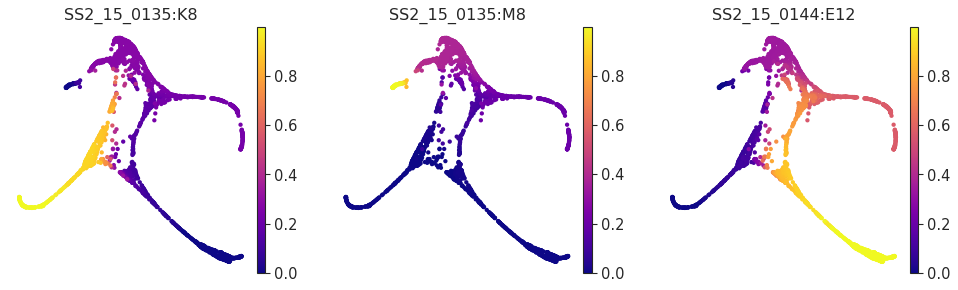

In [9]:
sc.pl.draw_graph(adata,color=pr_res.branch_probs.columns,cmap="plasma",frameon=False,save="palantir.pdf")

inferring a principal tree inferring a principal tree --> parameters used 
    400 principal points, sigma = 0.2, lambda = 1000, metric = euclidean
    fitting:  54%|█████▍    | 27/50 [00:02<00:02,  9.40it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.
inferring a principal tree inferring a principal tree --> parameters used 
    400 principal points, sigma = 0.2, lambda = 1000, metric = euclidean
    fitting: 100%|██████████| 50/50 [00:02<00:00, 17.09it/s]
    not converged (error: 0.005574668766418084)
    finished (0:00:03) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .u

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


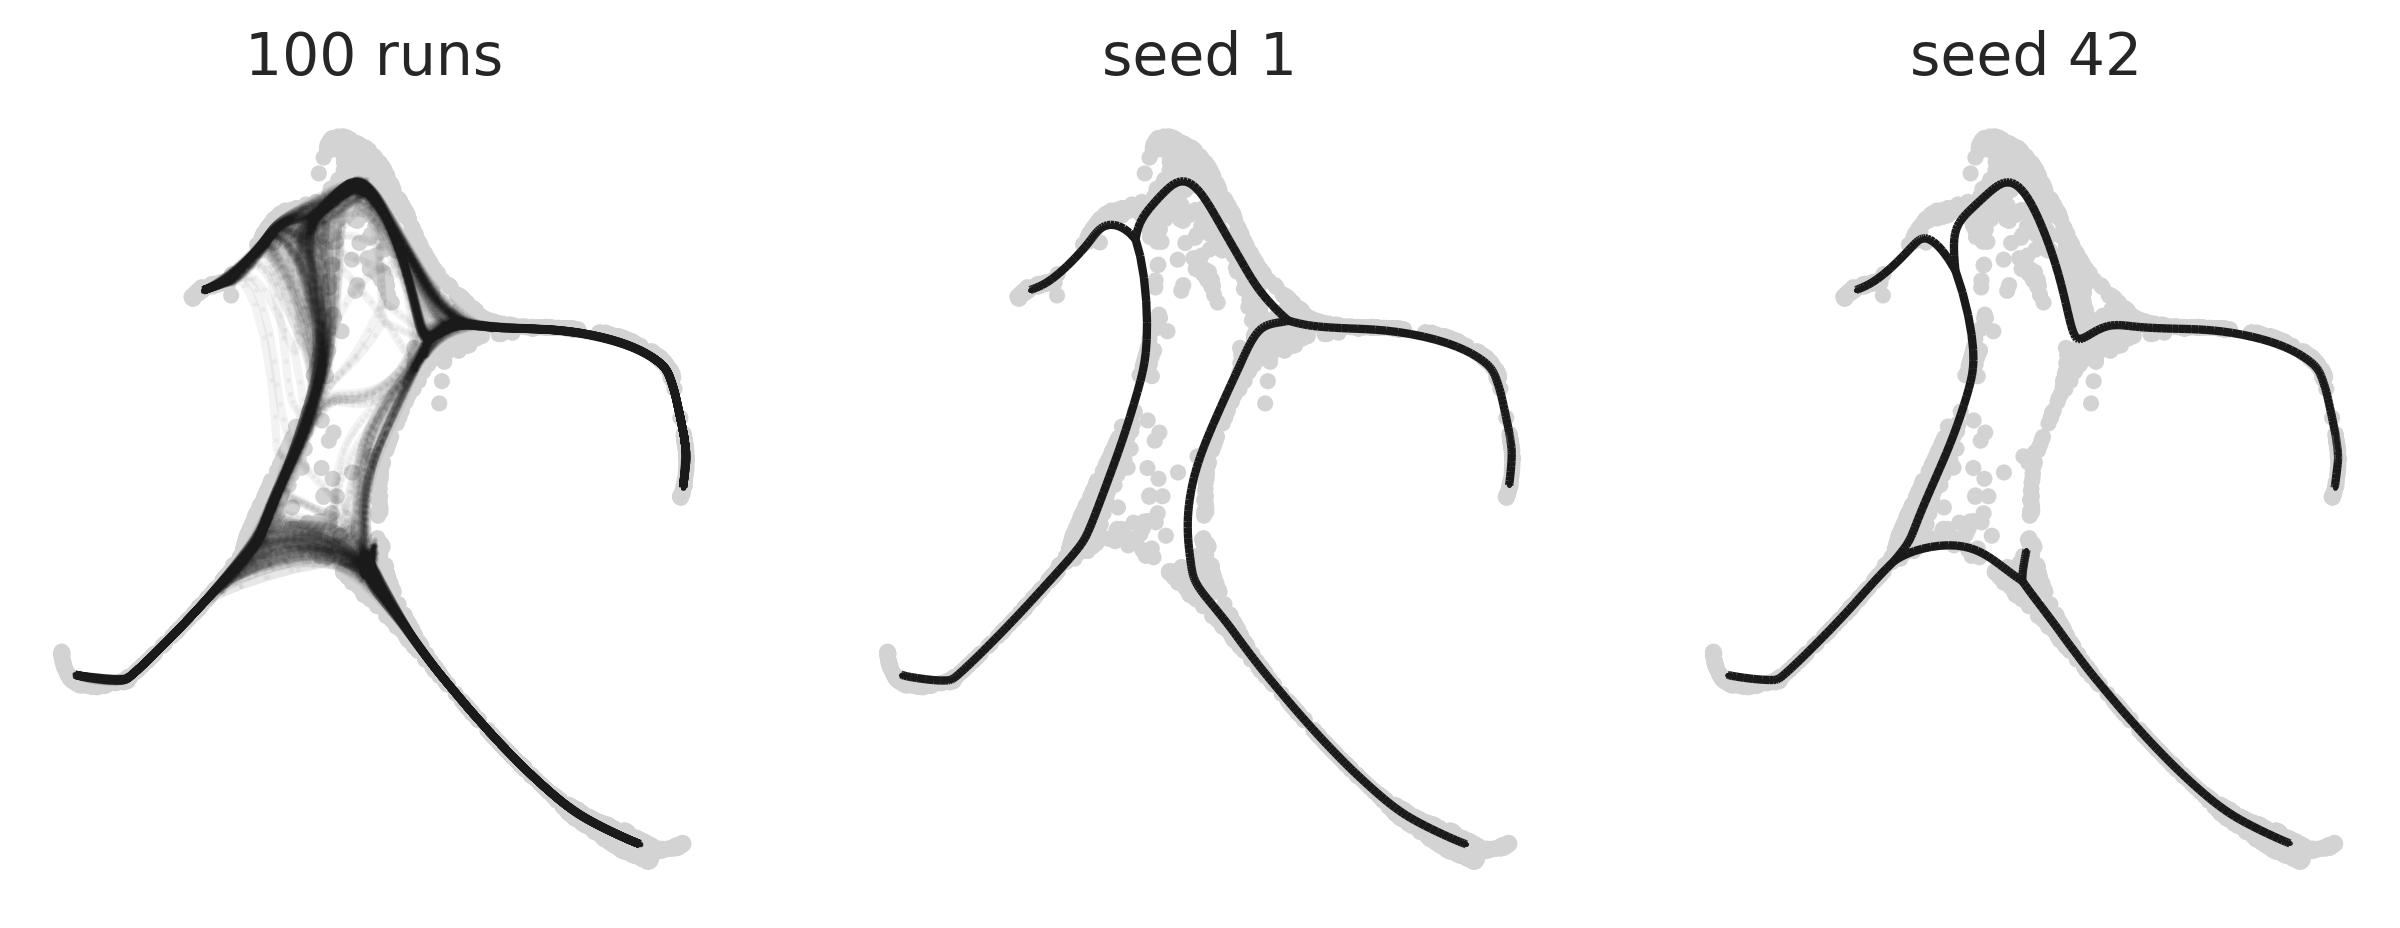

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm

sc.set_figure_params(frameon=False,dpi=150)
fig,axs=plt.subplots(1,3,figsize=(10,3.5))

sc.pl.draw_graph(adata,ax=axs[0],show=False)

scf.tl.tree(adata,Nodes=400,use_rep="X_msdiff",method="ppt",device="cpu",seed=42,ppt_lambda=1000,ppt_sigma=.2)
scf.pl.graph(adata,basis="draw_graph_fa",tips=False,forks=False,size_nodes=.1,ax=axs[2],show=False,title="seed 42")

scf.tl.tree(adata,Nodes=400,use_rep="X_msdiff",method="ppt",device="cpu",seed=1,ppt_lambda=1000,ppt_sigma=.2)
scf.pl.graph(adata,basis="draw_graph_fa",tips=False,forks=False,size_nodes=.1,ax=axs[1],show=False,title="seed 1")
scf.settings.verbosity=0
for i in tqdm(range(100)):
    scf.tl.tree(adata,Nodes=400,use_rep="X_msdiff",method="ppt",device="cpu",seed=i,ppt_lambda=1000,ppt_sigma=.2)
    scf.pl.graph(adata,basis="draw_graph_fa",tips=False,forks=False,size_nodes=.1,ax=axs[0],
                 show=False,alpha=0,alpha_seg=.05,alpha_nodes=.05)
    
axs[0].set_title("100 runs")
plt.savefig("figures/100runs.pdf",dpi=300)

In [11]:
adata_all=sc.read("data/adata_tree.h5ad")

In [12]:
adata=adata_all[adata_all.obs.leiden.isin(["14","15","16","17"])]

In [13]:
adata.obs["fate"] = "Ic"
adata.obs.loc[adata.obs.leiden.isin(["14","15"]),"fate"]="Ib"

Trying to set attribute `.obs` of view, copying.


In [14]:
scf.tl.curve(adata,Nodes=30,use_rep="X_msdiff",device="gpu",epg_mu=200,seed=1)

In [15]:
scf.tl.root(adata,1)
scf.tl.pseudotime(adata)

In [16]:
scf.tl.subset_tree(adata,t_min=2)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fate' as categorical


<AxesSubplot:xlabel='FA1', ylabel='FA2'>

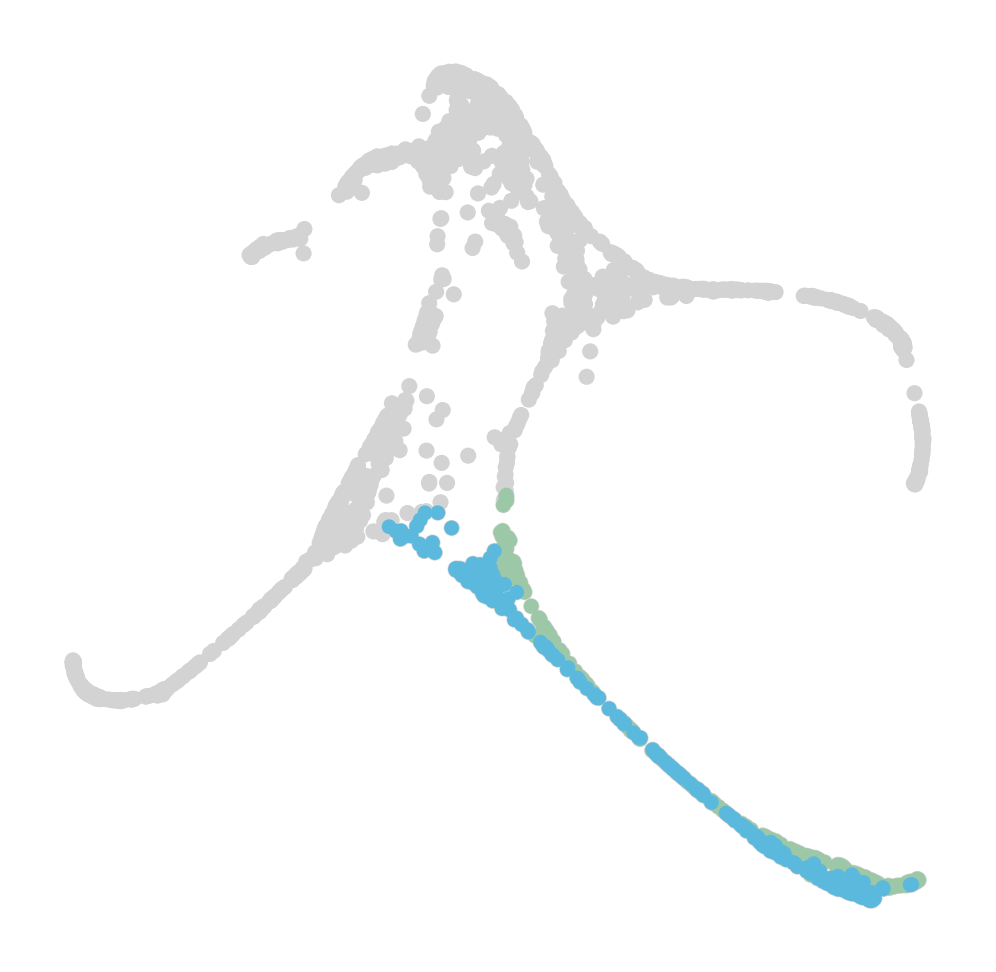

In [17]:
from matplotlib.lines import Line2D
ax=sc.pl.draw_graph(adata_all,show=False,frameon=False)
sc.pl.draw_graph(adata,color="fate",palette=["#5BB9DD","#9CC8A8"],
                 ax=ax,s=50,legend_loc="none",show=False,title="")


In [18]:
adata.obsm["X_draw_graph_fa"].min(axis=0)


array([ -7399.12211508, -14977.44488927])

In [19]:
adata.obsm["X_draw_graph_fa"].max(axis=0)

array([22061.12099638,   368.17749157])

In [20]:
adata_Ic=adata[adata.obs.fate=="Ic"]
adata_Ib=adata[adata.obs.fate=="Ib"]

In [21]:
scf.tl.curve(adata_Ic,Nodes=20,use_rep="X_msdiff",device="gpu",epg_mu=200,seed=1)
scf.tl.curve(adata_Ib,Nodes=20,use_rep="X_msdiff",device="gpu",epg_mu=200,seed=1)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [22]:
scf.tl.root(adata_Ib,1)
scf.tl.root(adata_Ic,1)
scf.tl.pseudotime(adata_Ib)
scf.tl.pseudotime(adata_Ic)

In [23]:
import numpy as np
dist=-(np.diff(adata_all.obsm["X_draw_graph_fa"].max(axis=0)-adata_all.obsm["X_draw_graph_fa"].min(axis=0))[0])

In [24]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


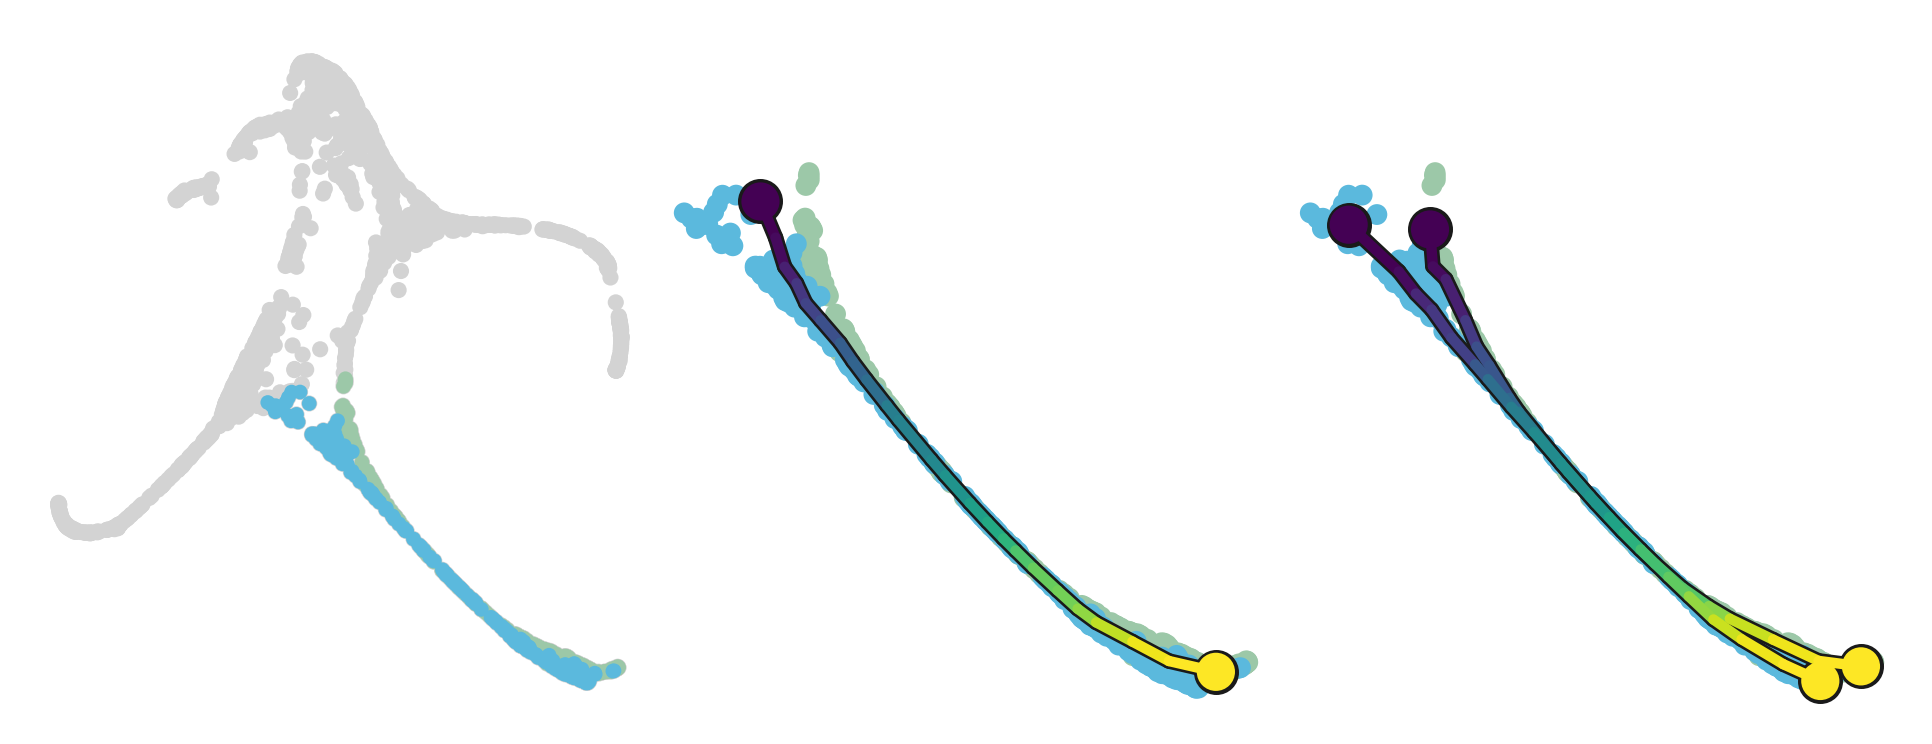

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv
scv.set_figure_params(dpi=150)
fig, axs = plt.subplots(2,3,sharex=True,gridspec_kw=dict(hspace=0.01,wspace=0.01,height_ratios=[.2,1]),figsize=(8,3))


scv.set_figure_params(dpi=150,figsize=(3,3),frameon=False)
sc.pl.draw_graph(adata,color="fate",palette=["#5BB9DD","#9CC8A8"],
                s=100,legend_loc="none",show=False,title="",ax=axs[1,2]);
scf.pl.trajectory(adata_Ic,basis="draw_graph_fa",scale_path=.5,show=False,frameon=False,alpha=0,ax=axs[1,2])
scf.pl.trajectory(adata_Ib,basis="draw_graph_fa",scale_path=.5,show=False,frameon=False,alpha=0,ax=axs[1,2])


scf.pl.trajectory(adata,basis="draw_graph_fa",scale_path=.7,legend_loc="none",title="",frameon=False,
                  color_cells="fate",palette=["#5BB9DD","#9CC8A8"],ax=axs[1,0],show=False)  

scf.pl.trajectory(adata,basis="draw_graph_fa",scale_path=.5,legend_loc="none",title="",frameon=False,s=100,
                  color_cells="fate",palette=["#5BB9DD","#9CC8A8"],ax=axs[1,1],show=False)


for ax in axs[:, 0]:
    ax.remove()
    
for ax in axs[0, 1:]:
    ax.remove()
    
gs = axs[0, 0].get_gridspec()
ax_emb = fig.add_subplot(gs[:, 0])
sc.pl.draw_graph(adata_all,show=False,frameon=False,ax=ax_emb)
sc.pl.draw_graph(adata,color="fate",palette=["#5BB9DD","#9CC8A8"],
                s=50,legend_loc="none",show=False,title="",ax=ax_emb);

plt.savefig("figures/supp_IbIc.pdf",dpi=300)

In [26]:
scf.tl.test_association_covariate(adata,"fate",A_cut=.5,n_jobs=40,fdr_cut=0.01)

    single mapping : 100%|██████████| 20699/20699 [00:17<00:00, 1166.17it/s]


In [27]:
scf.tl.test_covariate(adata,"fate",adata.var_names[adata.var.signi],
                        trend_test=False,n_jobs=40,fdr_cut=0.1)

    Covariate testing: 100%|██████████| 2035/2035 [00:03<00:00, 628.16it/s]


In [28]:
scf.tl.test_covariate(adata,"fate",adata.var_names[adata.var.signi],
                        trend_test=True,n_jobs=40,fdr_cut=0.1)

    Covariate testing: 100%|██████████| 2035/2035 [00:04<00:00, 471.30it/s]


In [29]:
sel=["cov_pval","cov_fdr","covtrend_pval","covtrend_fdr","Ib->Ic_lfc"]

In [30]:
df_notrend=adata.var.loc[(adata.var.cov_signi==1) & (adata.var.covtrend_pval>.1),sel].sort_values("Ib->Ic_lfc")

In [31]:
df_notrend

,cov_pval,cov_fdr,covtrend_pval,covtrend_fdr,Ib->Ic_lfc
gene,,,,,
Hs3st2,4.188296e-35,8.523183e-32,0.287023,1.0,-3.595340
Slit2,1.165179e-14,2.371138e-11,0.715957,1.0,-1.772583
Sptb,2.327101e-11,4.735651e-08,0.179239,1.0,-1.702874
Plekha5,2.526676e-13,5.141785e-10,0.275011,1.0,-1.331980
Tmem117,3.820848e-13,7.775426e-10,0.212480,1.0,-1.232641
Dab2ip,2.858653e-06,5.817359e-03,0.201097,1.0,-1.122995
Rnf150,1.854615e-06,3.774141e-03,0.414257,1.0,-1.076851
Stk32b,3.386899e-05,6.892340e-02,0.783163,1.0,-1.057042
Epha3,6.795725e-07,1.382930e-03,0.160266,1.0,-1.052977


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


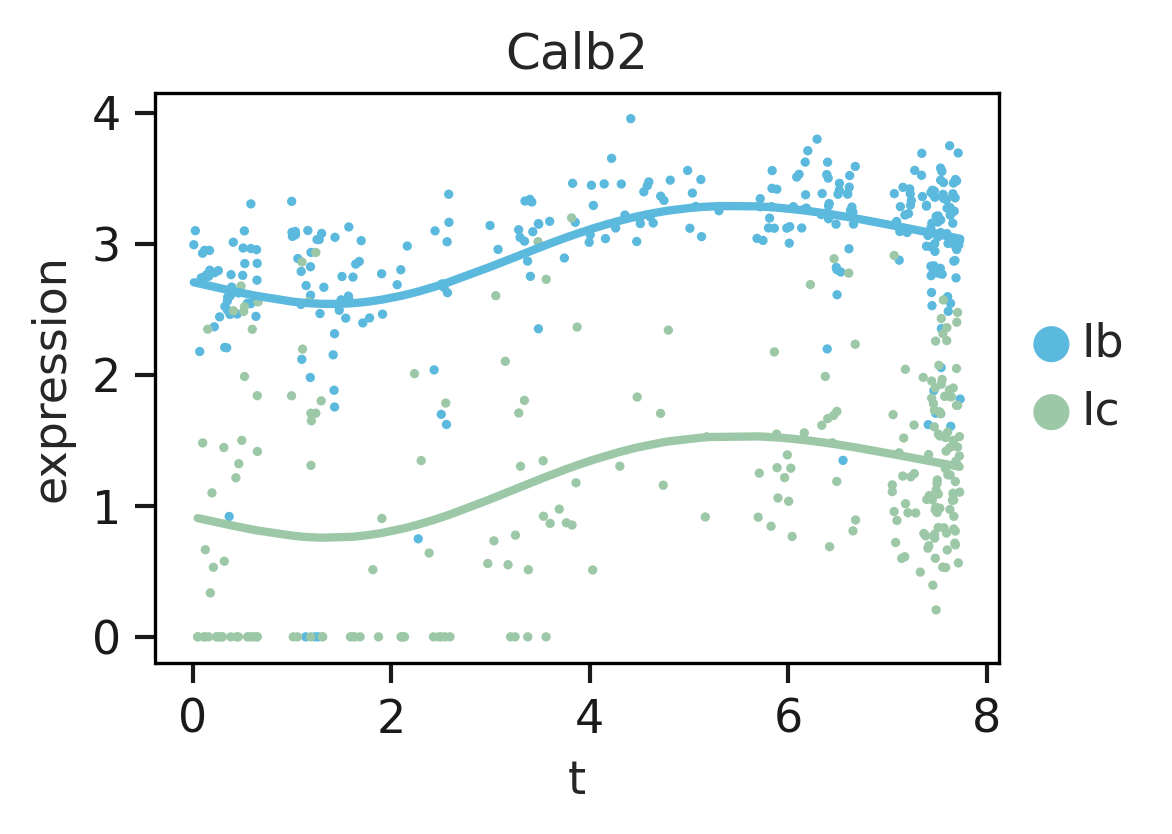

In [32]:
scv.set_figure_params(figsize=(4,2.5),dpi=150)
scf.pl.trend_covariate(adata,"Calb2","fate",size=20)

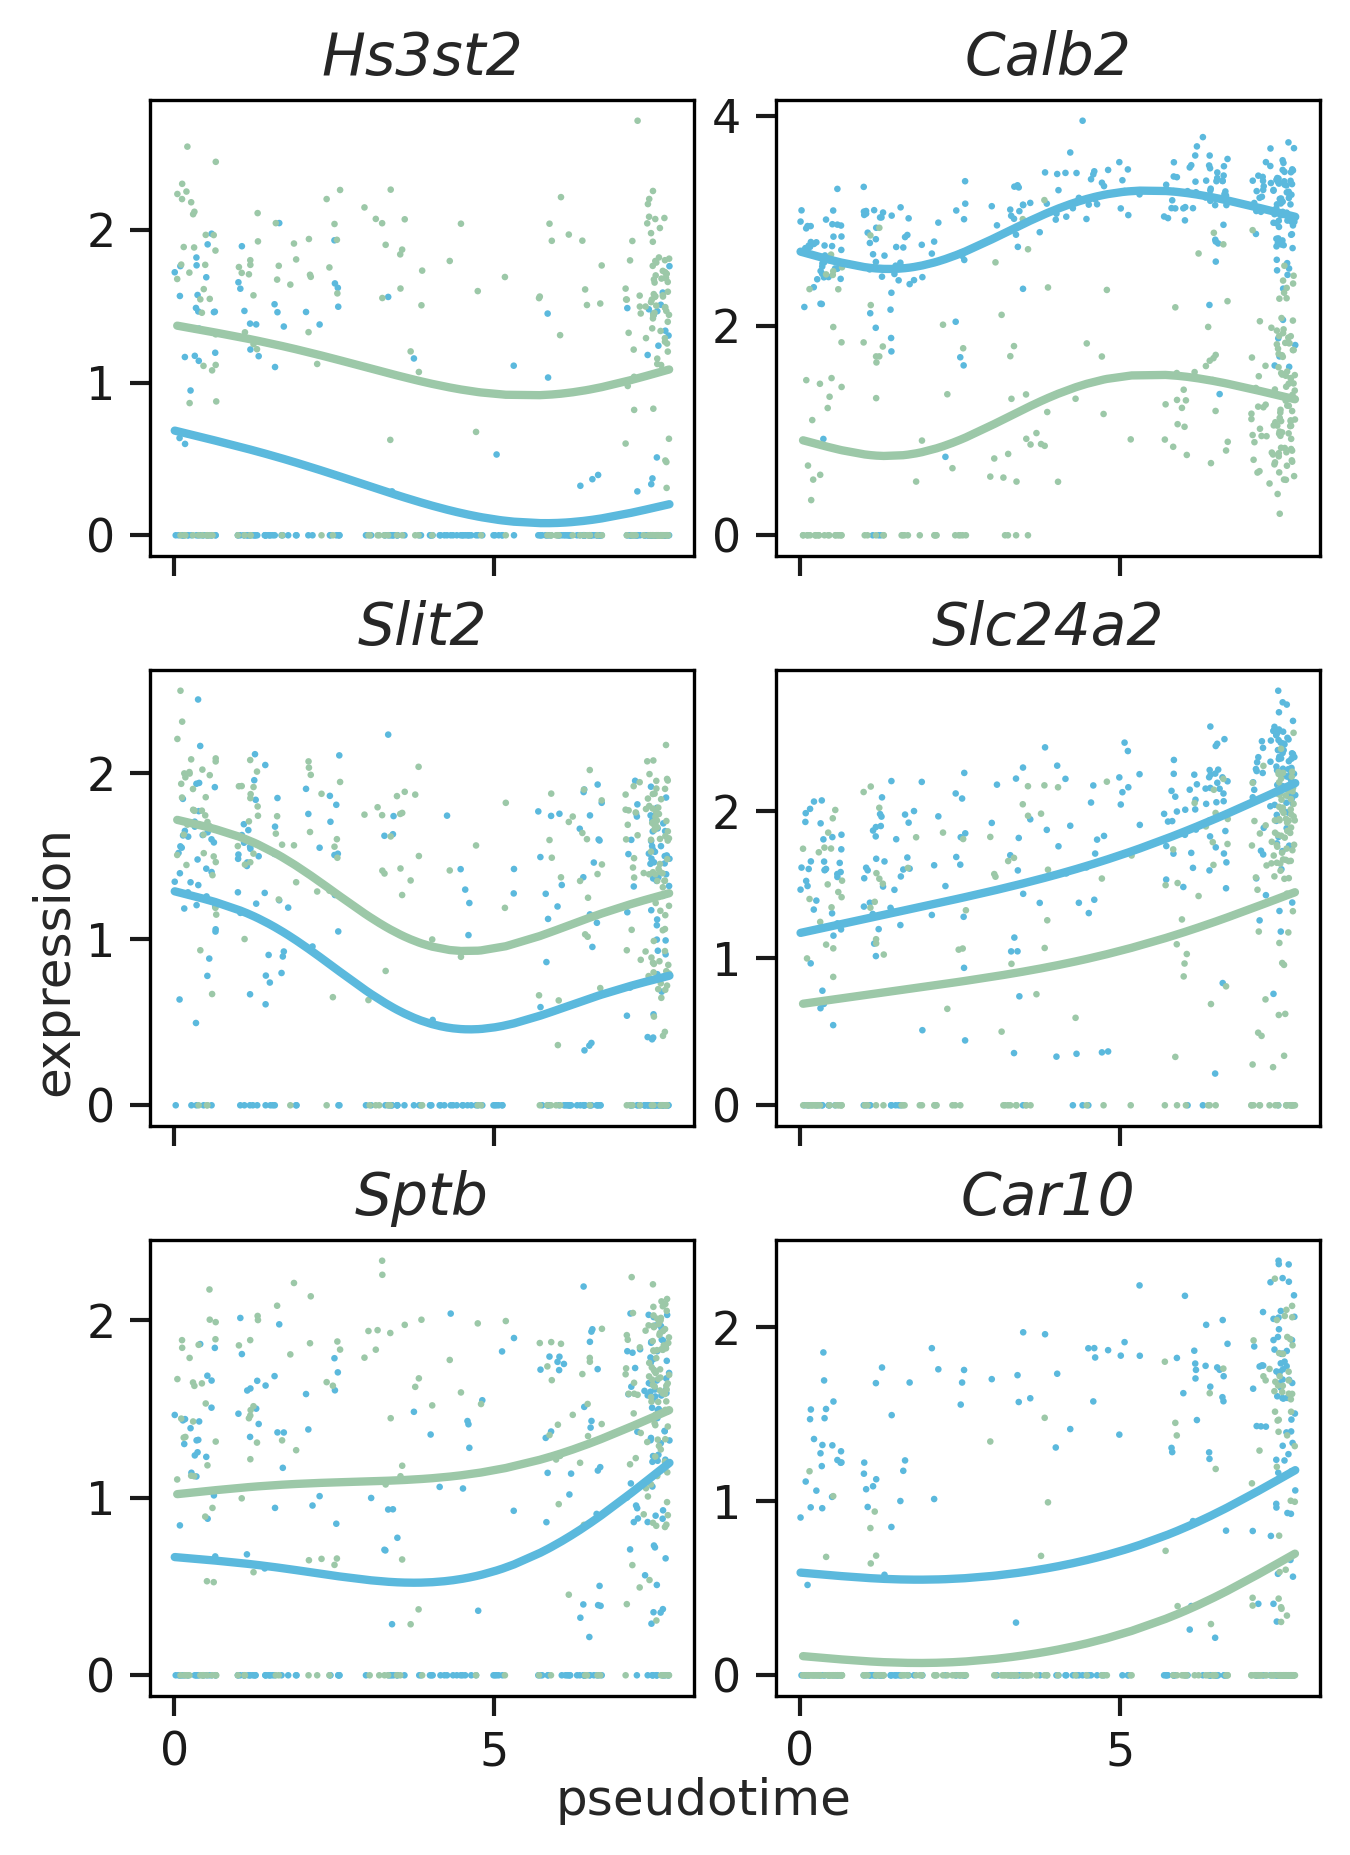

In [77]:
scv.set_figure_params(dpi=150)
fig,axs=plt.subplots(3,2,sharex=True,figsize=(5,7),gridspec_kw=dict(wspace=.15,hspace=.25))
axs=axs.T.ravel()
for i,g in enumerate(df_notrend.index[:3]):
    scf.pl.trend_covariate(adata,g,"fate",ax=axs[i],show=False,size=10,legend_loc="none")
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(g,style="italic",fontsize=14)
    
for i,g in enumerate(df_notrend.index[-3:][::-1]):
    scf.pl.trend_covariate(adata,g,"fate",ax=axs[i+3],show=False,size=10,legend_loc="none")
    axs[i+3].set_ylabel("")
    axs[i+3].set_title(g,style="italic",fontsize=14)
    axs[i+3].set_xlabel("")

        
fig.text(0.1, 0.5, 'expression', va='center', rotation='vertical')
fig.text(0.45, 0.1, 'pseudotime', va='center')
plt.savefig("figures/cov_test_amp.pdf",dpi=300)

In [43]:
df_trend=adata.var.loc[(adata.var.covtrend_signi==1),sel].sort_values("Ib->Ic_lfc")

In [44]:
df_trend

,cov_pval,cov_fdr,covtrend_pval,covtrend_fdr,Ib->Ic_lfc
gene,,,,,
D130009I18Rik,3.800684e-99,7.734392e-96,3.757283e-05,7.646070e-02,-5.235542
Espn,1.319811e-41,2.685816e-38,5.602099e-06,1.140027e-02,-3.317160
Ccdc109b,1.164328e-31,2.369408e-28,1.547229e-13,3.148610e-10,-3.313590
Crtac1,3.726725e-10,7.583884e-07,3.151059e-05,6.412405e-02,-1.741545
Sorcs3,1.564338e-07,3.183428e-04,9.240561e-08,1.880454e-04,-1.582641
Kcnip3,1.668673e-07,3.395750e-04,9.060674e-06,1.843847e-02,-1.371875
Ckmt1,5.730661e-18,1.166190e-14,1.966370e-07,4.001563e-04,-1.294815
Fmn1,4.397112e-08,8.948124e-05,1.282633e-05,2.610158e-02,-1.168791
Kcnip2,2.136238e-07,4.347245e-04,7.954054e-06,1.618650e-02,-1.109668


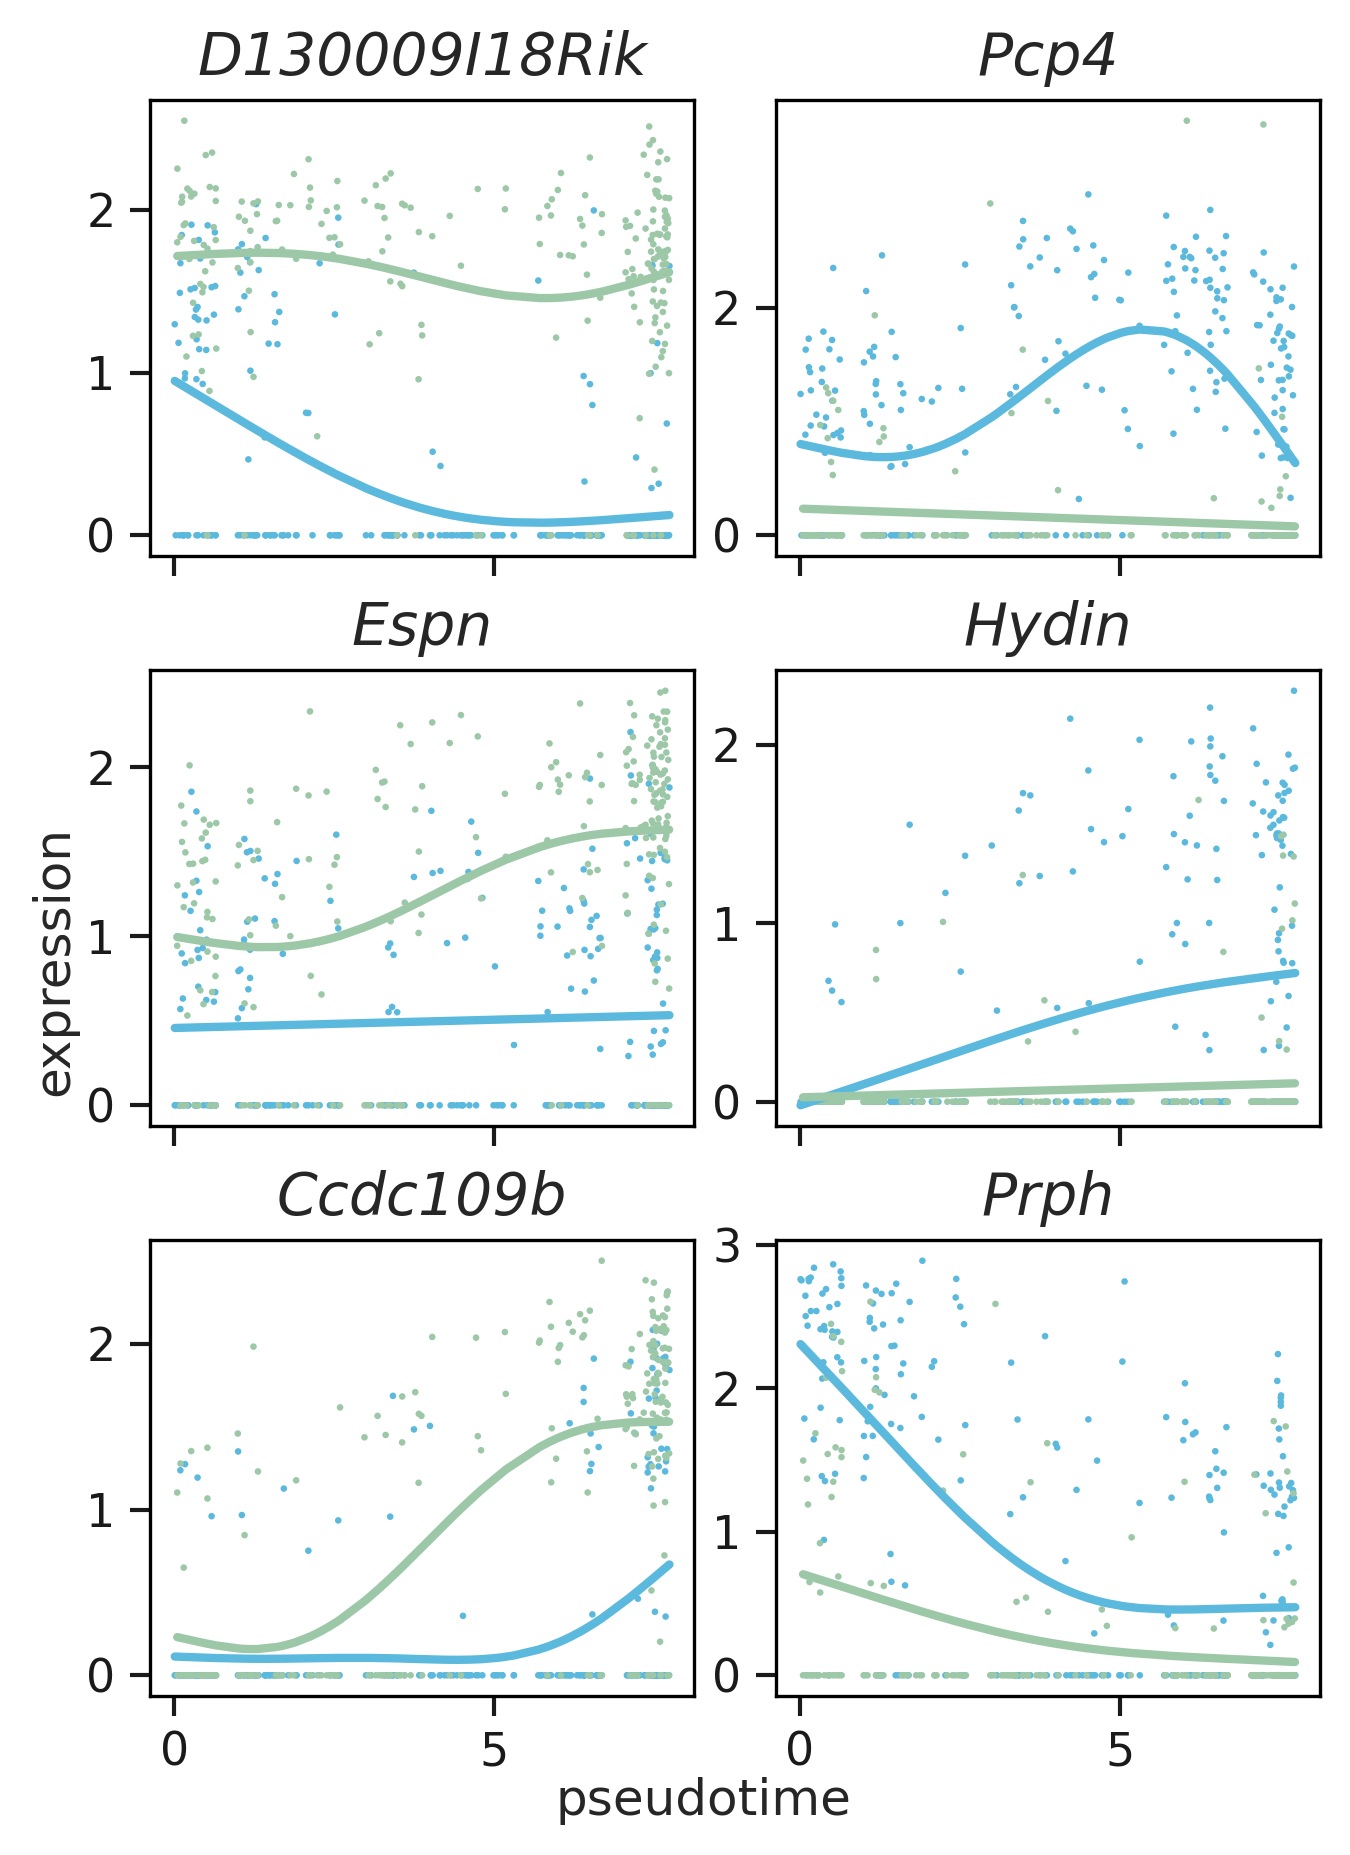

In [78]:
scv.set_figure_params(dpi=150)
fig,axs=plt.subplots(3,2,sharex=True,figsize=(5,7),gridspec_kw=dict(wspace=.15,hspace=.25))
axs=axs.T.ravel()
for i,g in enumerate(df_trend.index[:3]):
    scf.pl.trend_covariate(adata,g,"fate",ax=axs[i],show=False,size=10,legend_loc="none")
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(g,style="italic",fontsize=14)
    
for i,g in enumerate(df_trend.index[-3:][::-1]):
    scf.pl.trend_covariate(adata,g,"fate",ax=axs[i+3],show=False,size=10,legend_loc="none")
    axs[i+3].set_ylabel("")
    axs[i+3].set_title(g,style="italic",fontsize=14)
    axs[i+3].set_xlabel("")

        
fig.text(0.1, 0.5, 'expression', va='center', rotation='vertical')
fig.text(0.45, 0.1, 'pseudotime', va='center')
plt.savefig("figures/cov_test_trend.pdf",dpi=300)

In [95]:
genecheck=df_trend.loc[df_trend.cov_fdr<0.05].index

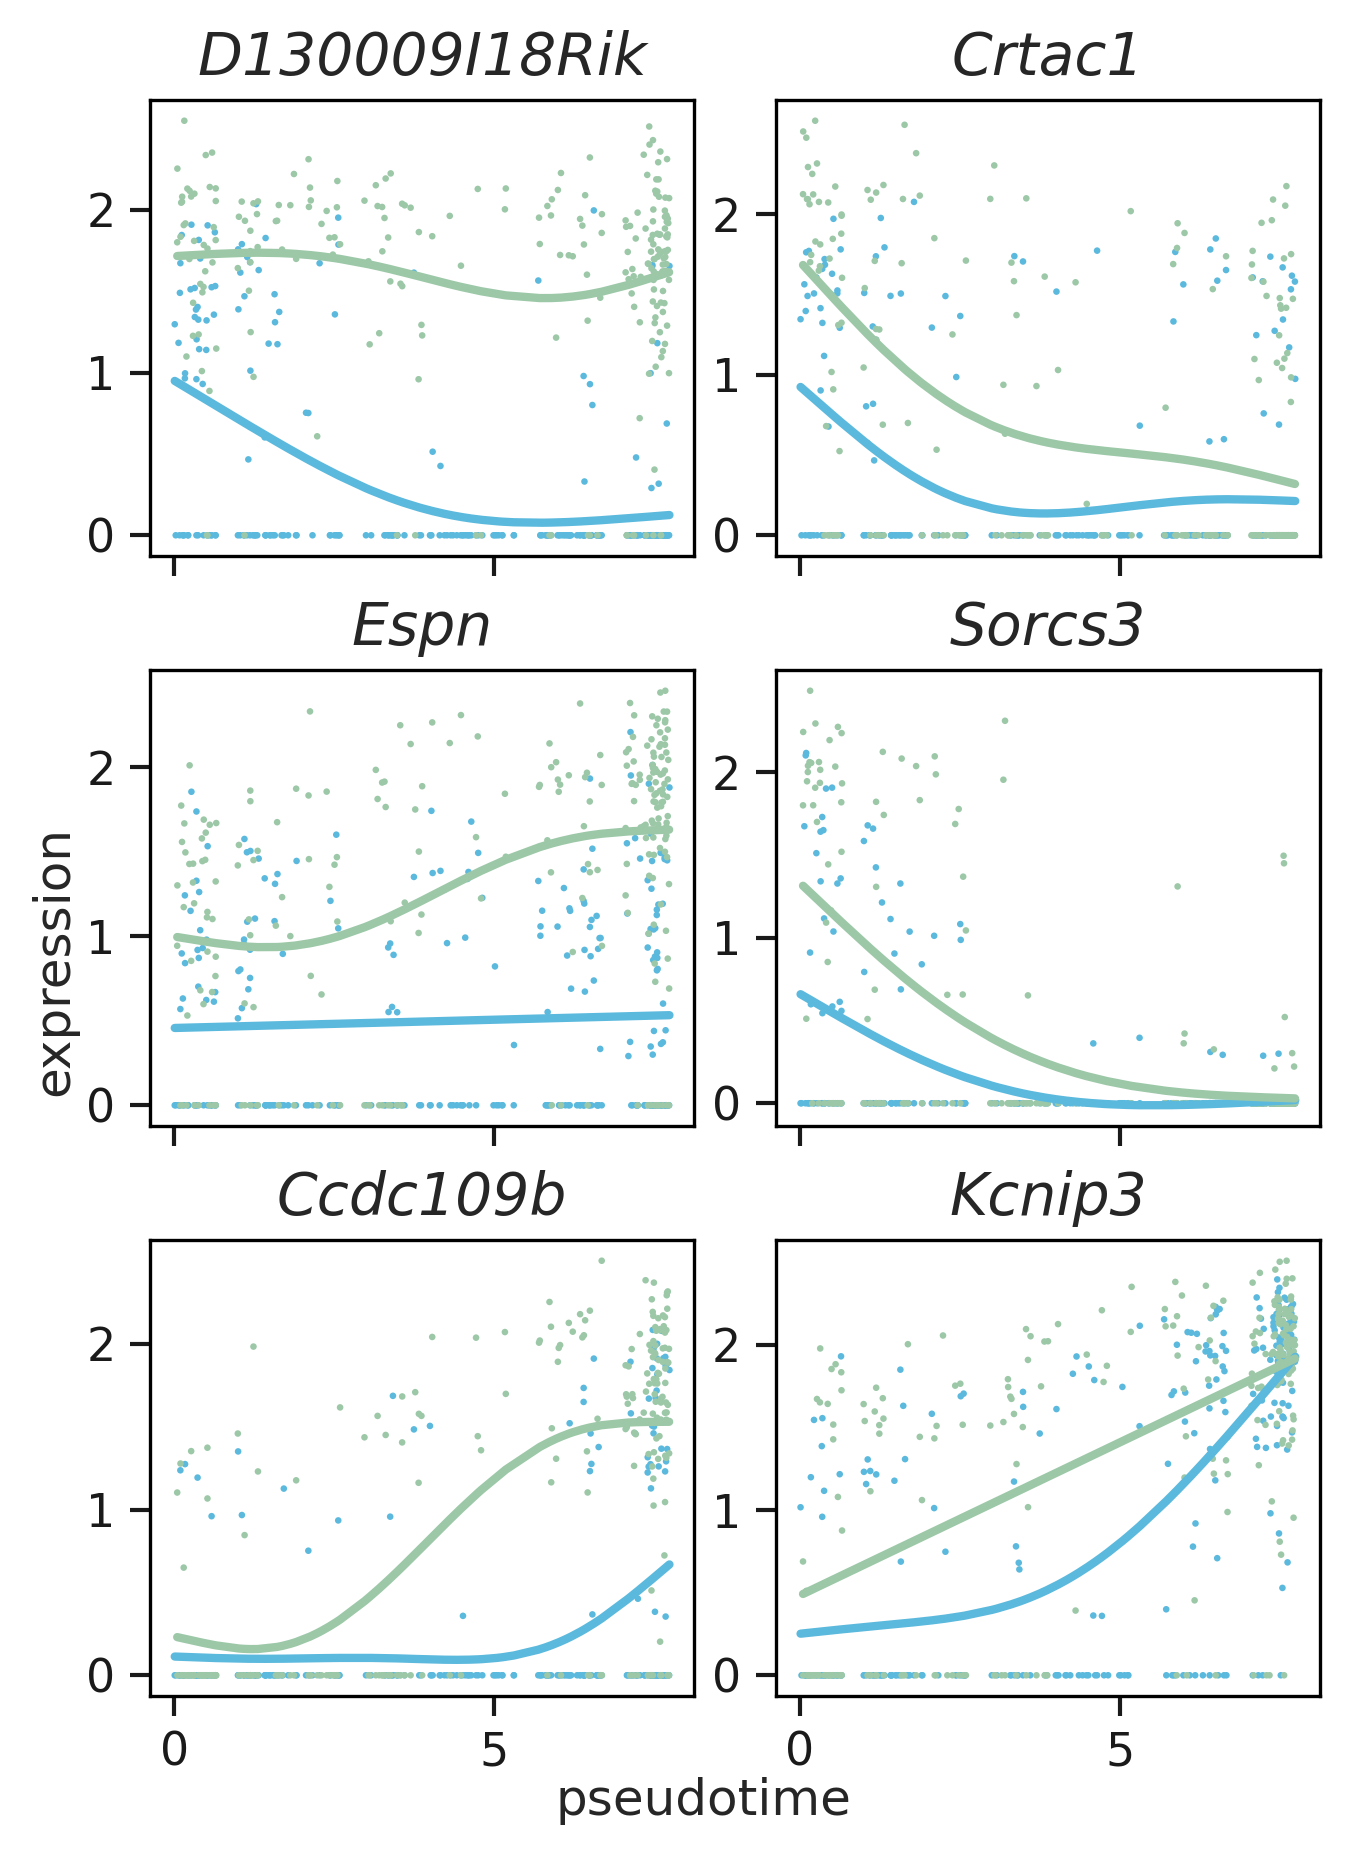

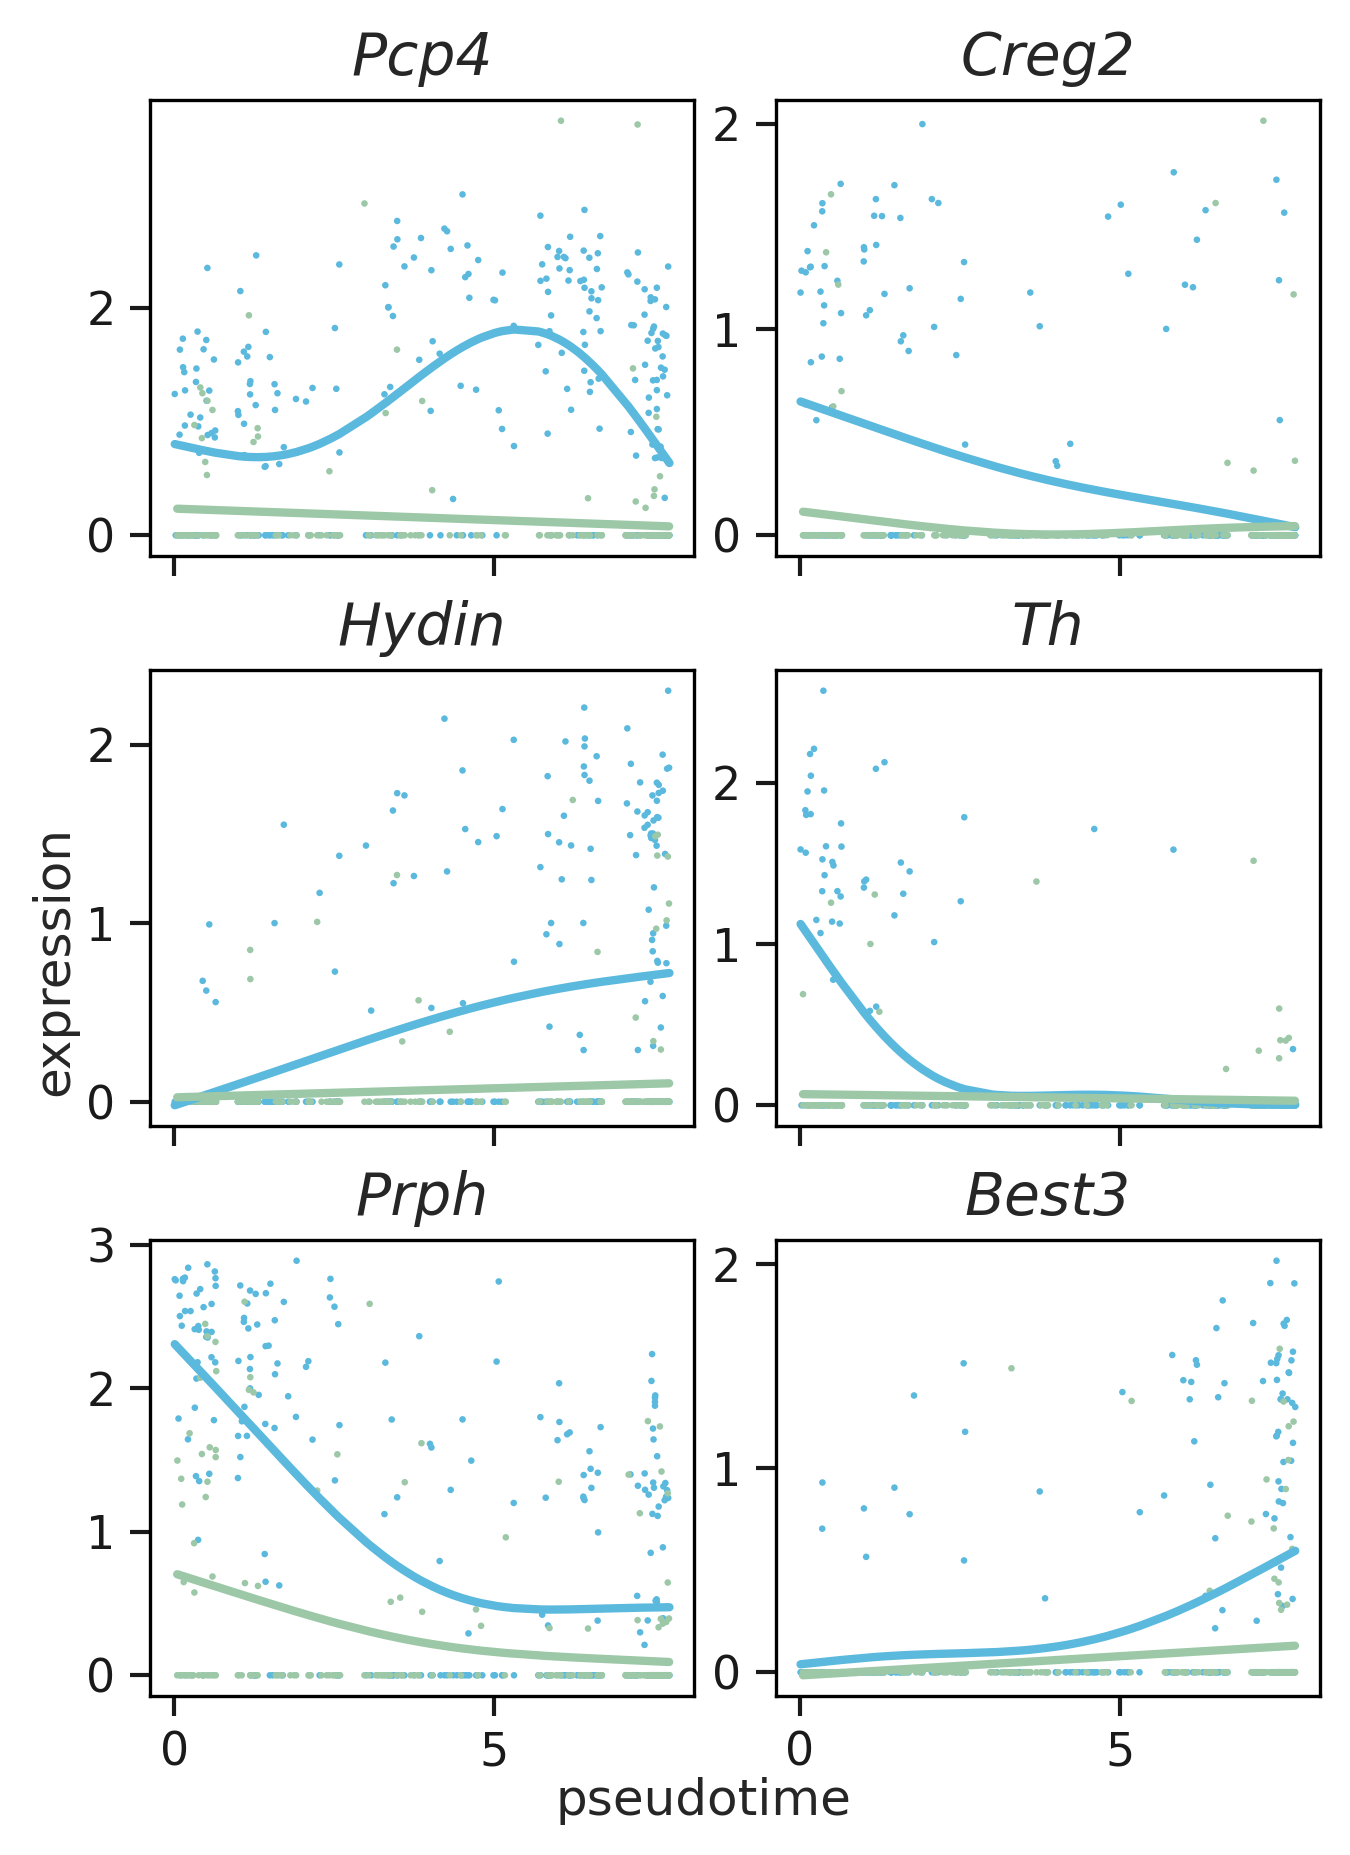

In [101]:
fig,axs=plt.subplots(3,2,sharex=True,figsize=(5,7),gridspec_kw=dict(wspace=.15,hspace=.25))
axs=axs.T.ravel()
for i,g in enumerate(genecheck[:6]):
    scf.pl.trend_covariate(adata,g,"fate",ax=axs[i],show=False,size=10,legend_loc="none")
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(g,style="italic",fontsize=14)
    
fig.text(0.1, 0.5, 'expression', va='center', rotation='vertical')
fig.text(0.45, 0.1, 'pseudotime', va='center')
plt.savefig("figures/supp_IbIc_d.pdf")   
fig,axs=plt.subplots(3,2,sharex=True,figsize=(5,7),gridspec_kw=dict(wspace=.15,hspace=.25))
axs=axs.T.ravel()
for i,g in enumerate(genecheck[-6:][::-1]):
    scf.pl.trend_covariate(adata,g,"fate",ax=axs[i],show=False,size=10,legend_loc="none")
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(g,style="italic",fontsize=14)
    
fig.text(0.1, 0.5, 'expression', va='center', rotation='vertical')
fig.text(0.45, 0.1, 'pseudotime', va='center')
plt.savefig("figures/supp_IbIc_e.pdf")   

In [102]:
fname="supp_Tree"

In [103]:
%%bash -s $fname

cat<<EOF >$1.tex
\documentclass{article}
\usepackage[paperheight=185mm,paperwidth=210mm]{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=5mm,}
 
\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphbox,graphicx} 
\usepackage{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\large 

\fontsize{11pt}{11pt}\selectfont

\begin{minipage}[t]{.71\textwidth}
\vspace{0cm}
\raggedright \textbf{a} Detected branches by Palantir
\center \includegraphics[width=\textwidth]{figures/draw_graph_fapalantir.pdf}

\raggedright \textbf{b} 100 unsupervised trees generated from scFates with different initialisations
\center \includegraphics[width=\textwidth]{figures/100runs.pdf}

\raggedright \textbf{c} Covariate comparison supports the semi-supervised trajectories
\center \includegraphics[width=\textwidth]{figures/supp_IbIc_a.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{.29\textwidth}
\vspace{0cm}
\raggedright \textbf{d} DE genes (Ic)
\includegraphics[width=\textwidth]{figures/supp_IbIc_d.pdf}
\raggedright \textbf{e} DE genes (Ib)
\includegraphics[width=\textwidth]{figures/supp_IbIc_e.pdf}

\end{minipage}\hfill
\hfill
\clearpage
EOF
echo "\end{document}" >> $1.tex

xelatex --shell-escape $1.tex
rm $1.tex
convert -flatten -density 300 $1.pdf $1.jpg

identify $1.pdf

This is XeTeX, Version 3.14159265-2.6-0.999991 (TeX Live 2019/Debian) (preloaded format=xelatex)
 \write18 enabled.
entering extended mode
(./supp_Tree.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption.sty
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption3.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/xetex.def))
(/usr/share/texlive/texmf

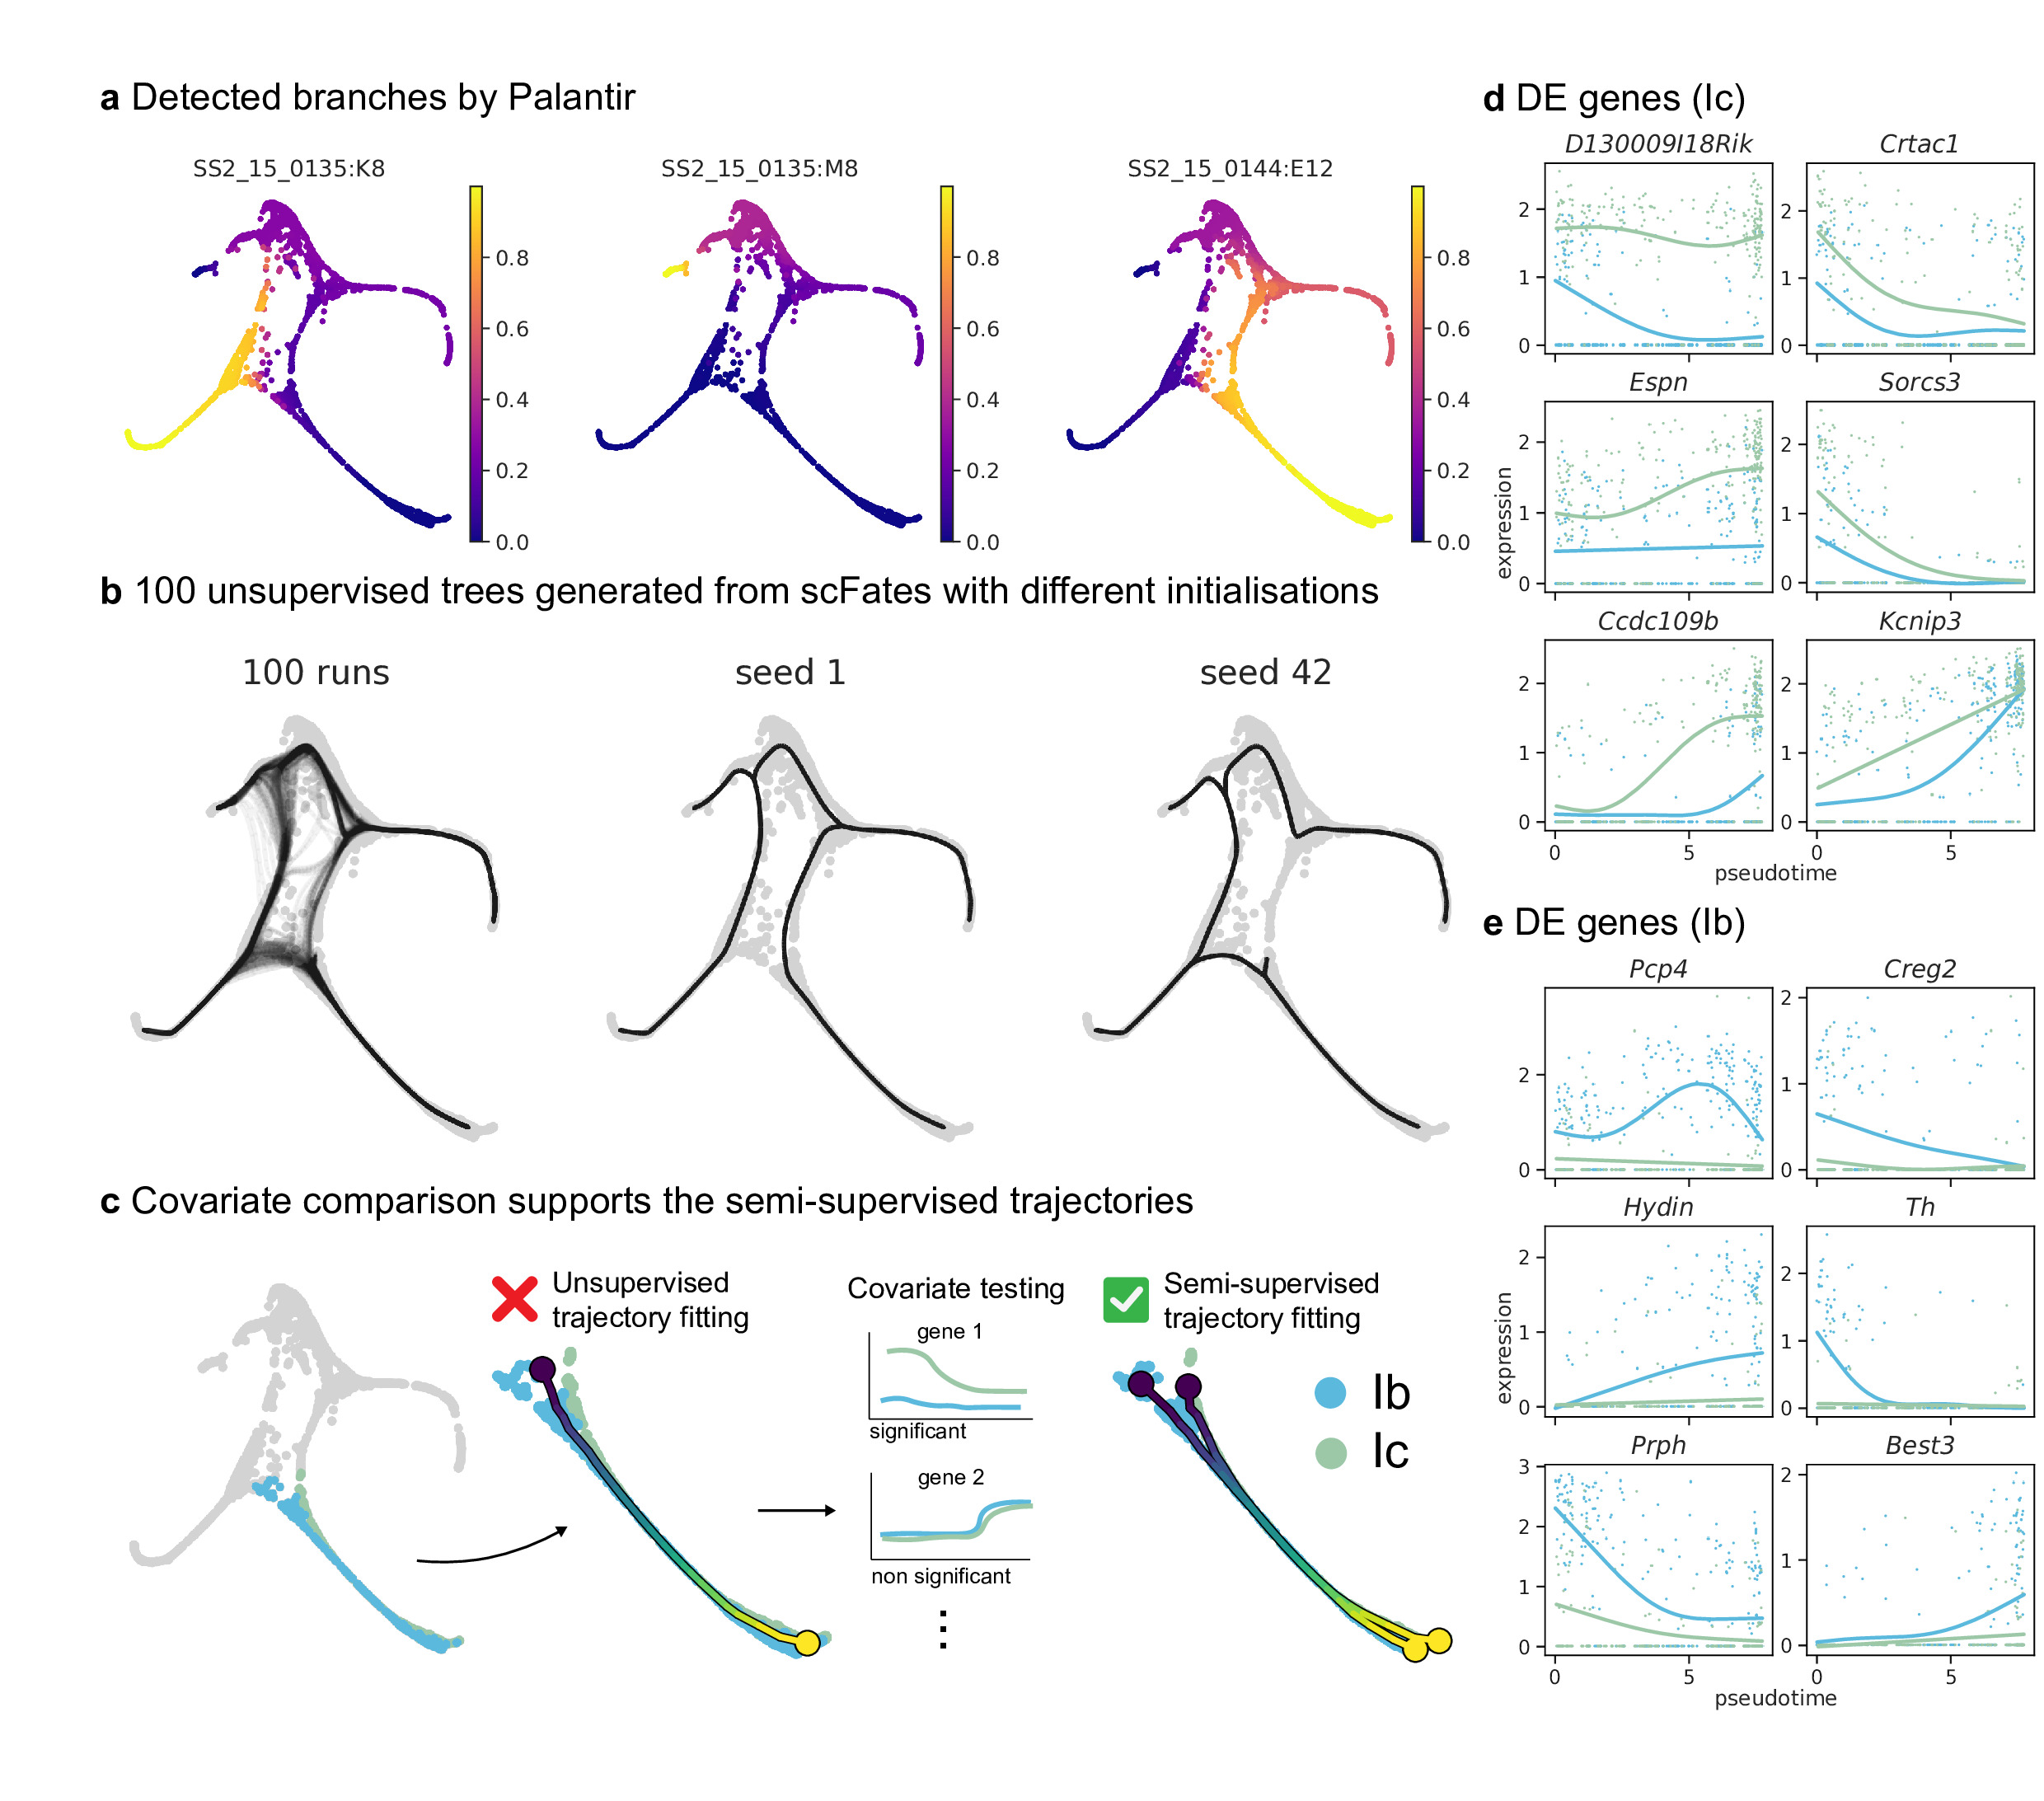

In [104]:
from IPython.display import Image
Image(filename=fname+'.jpg') 